## Before submitting
1. Before you turn your submission in, make sure everything runs as expected. `Kernel `$\rightarrow$` Restart and Run All Cells`

2. Make sure that no assertions fail or exceptions occur, otherwise points will be subtracted.

3. After you submit the notebook more tests will be run on your code. The fact that no assertions fail on your computer localy does not guarantee that you completed the exercise correctly.


4. Please submit only the edited original `*.ipynb` file. Do NOT rename the file

5. Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Edit only between `YOUR CODE HERE` and `END YOUR CODE`.

6. Make sure to use Python 3, not Python 2.

7. Read the notebook thoroughly.

8. Only work on the exercises using Jupyter Notebook. While tools such as PyCharm and VS Code support the `ipynb` format, they overwrite crucial metadata, which break the autograder system.

9. Do **NOT** under any circustances delete any cells that you didn't insert yourselves. If you accidentally delete a cell either undo the deletion using `Edit` $\rightarrow$ `Undo Delete Cells` or re-download the notebook file from ISIS and paste your existing code in there. 

Fill your group name and members below:

In [1]:
GROUPNAME = ""
COLLABORATORS = ""

In [2]:
import sys
assert sys.version_info >= (3,6), 'You need to be running at least Python version 3.6'

In [3]:
# This cell is for grading. DO NOT remove it

# Use unittest asserts
import unittest; t = unittest.TestCase()
from pprint import pprint


# Exercise Sheet 2: Timing, Numpy, Plotting

The previous exercise sheet introduced several methods for classification: decision trees, nearest neighbors, and nearest means. Of those, the one that could learn from the data, and that also offered enough complexity to produce an accurate decision function was k-nearest neighbors. However, nearest neighbors can be slow when implemented in pure Python (i.e. with loops). This is especially the case when the number of data points or input dimensions is large.

In this exercise sheet, we will speed up nearest neighbors by utilizing `numpy` and `scipy` packages. Your task will be to **replace list-based operations by vector-based operations** between numpy arrays. The speed and correctness of the implementations will then be tested. In particular, performance graphs will be drawn using the library `matplotlib`.

Make sure to have installed all the required packages (e.g. sklearn, scipy). For this you can e.g. use `conda install <package>` or `pip install <package>`. Make sure that you restart the Jupyter Server after you have installed any packages.

## Python Nearest Neighbor

The most basic element of computation of nearest neighbors is its distance function relating two arbitrary data points `x1` and `x2`. We assume that these points are iterable (i.e. we can use a loop over their dimensions). One way among others to compute the **square** Euclidean distance between two points is by computing the sum of the component-wise distances.

In [4]:
def pydistance(x1: 'Vector', x2: 'Vector') -> float:
    '''
    Calculates the square eucledian distance between two data points x1, x2
    
    Args:
        x1, x2 (vector-like): Two vectors (ndim=1) for which we want to calculate the distance
            `len(x1) == len(x2)` will always be True
        
    Returns: 
        float: The square eucleadian distance between the two vectors
    '''
    return sum([(x1d - x2d) ** 2 for x1d, x2d in zip(x1, x2)])

In [5]:
x1, x2 = [1, 4, 3, 2], [4, 8, -2, 2]
print(f'pydistance({x1}, {x1}) --> {pydistance(x1, x1)}')
print(f'pydistance({x1}, {x2}) --> {pydistance(x1, x2)}')

pydistance([1, 4, 3, 2], [1, 4, 3, 2]) --> 0
pydistance([1, 4, 3, 2], [4, 8, -2, 2]) --> 50


where we use the prefix "`py-`" of the function to indicate that the latter makes use of pure `Python` instead of `numpy`. Once the distance matrix has been implemented, the nearest neighbor for a given unlabeled point `u` that we would like to classify is obtained by iterating over all points in the training set `(X, Y)`, selecting the point with smallest distance to `u`, and returning its corresponding label. Here `X` denotes the list of inputs in the training set and `Y` denotes the list of labels.

In [6]:
def pynearest(u: list, X: list, Y: list, distance: callable = pydistance) -> int:
    '''
    Applies the nearest neighbour to the input `u`
    with training set `X` and labels `Y`. The 
    distance metric can be specified using the
    `distance` argument.
    
    Args:
        u (list): The input vector for which we want a prediction
        X (list): A 2 dimensional list containing the trainnig set
        Y (list): A list containing the labels for each vector in the training set
        distance (callable): The distance metric. By default the `pydistance` function
        
    Returns: 
        int: The label of the closest datapoint to u in X
    '''
    xbest = None
    ybest = None
    dbest = float('inf')
    
    for x, y in zip(X, Y):
        d = distance(u, x)
        if d < dbest:
            ybest = y
            xbest = x
            dbest = d
            
    return ybest

Note that this function either uses function `pydistance` (given as default if the argument distance is not specified). Or one could specify as argument a more optimized function for distance compuation, for example, one that uses `numpy`. Finally, one might not be interested in classifying a single point, but many of them. The method below receives a collection of such unlabeled test points stored in the variable `U`. The function returns a list of predictions associated to each test point.

In [7]:
def pybatch(U, X, Y, nearest=pynearest, distance=pydistance):
    '''
    Applies the nearest neighbor algorithm, to all the datapoints
    `u` $\in$ `U`, with `X` the training set and `Y` the labels.
    Both the distance metric and the method of finding the 
    neearest neighbor can be specified.
    
    Args:
        U (list): List of vectors for which a prediction is desired.
        X (list): A 2 dimensional list containing the trainnig set
        Y (list): A list containing the labels for each vector in the training set
        nearest (callable): The method by which the nearest neighbor search happens.
        distance (callable): The distance metric. By default the `pydistance` function
        
    Returns: 
        list: A list of predicted labels for each `u` $\in$ `U`
    '''
    return [nearest(u, X, Y, distance=distance) for u in U]

Again, such function uses by default the Python nearest neighbor search (with a specified distance function). However, we can also specified a more optimized nearest neighbor function, for example, based on `numpy`. Finally, one could consider an alternative function to `pybatch` that would use `numpy` from the beginning to the end. The implementation of such more optimized functions, and the testing of their correct behavior and higher performance will be the objective of this exercise sheet.

## Testing and correctness

As a starting point, the code below tests the output of the nearest neighbor algorithm for some toy dataset with fixed parameters. In particular, the function `data.toy(M,N,d)` generates a problem with `M` unlabeled test points stored in a matrix `U` of size `(M x d)`, then `N` labeled training points stored in a matrix `X` of size `(N x d)` and the output label is stored in a vector `Y` of size `N` composed of zeros and ones encoding the two possible classes. The variable `d` denotes the number of dimensions of each point. The toy dataset is pseudo-random, that is, for fixed parameters, it produce a random-looking dataset, but every time the method is called with the same parameters, the dataset is the same. The pseudo-randomness property will be useful to verify that each nearest neighbor implementation performs the same overall computation. Please check the `data.py` file within the exercise folder for the implementation details. 

In [8]:
import os
if 'data.py' not in os.listdir():
    t.fail('Did you download the \'data.py\' file from ISIS?')
    

import data
U, X, Y = data.toy(20, 100, 50)

print(f'Shape of U (unlabeled datapoints): {U.shape}')
print(f'Shape of X (training set): {X.shape}')
print(f'Shape of Y (labels): {Y.shape}')
print(f'Predictions: {pybatch(U, X, Y)}')

Shape of U (unlabeled datapoints): (20, 50)
Shape of X (training set): (100, 50)
Shape of Y (labels): (100,)
Predictions: [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


In particular, the output of this function will help us to verify that the more optimized `numpy`-based versions of nearest neighbor are still valid.

## Plotting and performance

We now describe how to build a plot that relates a certain parameter of the dataset (e.g. the number of input dimensions `d` to the time required for the computation. We first initialize the basic plotting environment.

In [9]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 90

The command "`%matplotlib inline`" tells IPython notebook that the plots should be rendered inside the notebook. 

The following code plots the computation time of predicting `100` points from the test set using a training set of size `100`, and where we vary the number of input dimensions. The measurement of time happens with the `timeit` module. `timeit` provides many convinience functions for benchmarking. In particular the repeat function runs the provided code many times and returns the time it took to run it. You can find more information about `repeat` [here](https://docs.python.org/3/library/timeit.html#timeit.repeat)

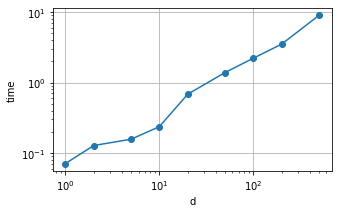

In [10]:
import timeit
from statistics import mean

# Values for the number of dimensions d to test
dlist = [1, 2, 5, 10, 20, 50, 100, 200, 500]

# Measure the computation time for each choice of number of dimensions d
tlist = []
for d in dlist:
    U, X, Y = data.toy(100, 100, d)  
    # get the average of three runs
    delta = mean(timeit.repeat(lambda : pybatch(U,X,Y), number=1, repeat=3))
    tlist.append(delta)

# Plot the results in a graph
fig = plt.figure(figsize=(5, 3))
plt.plot(dlist, tlist, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)

The time on the vertical axis is in seconds. Note that the exact computation time depends on the speed of your computer. As expected, the computation time increases with the number of input dimensions. Unfortunately, for the small dataset considered here (`100` training and test points of `100` dimensions each), the algorithm already takes more than one second to execute. Thus, it is necessary for practical applications (e.g. the digit recognition task that we will consider at the end of this exercise sheet) to accelerate this nearest neighbor algorithm.

## 1. Accelerating the distance computation (25 P)

In this first exercise, we would like to accelerate the function that compute pairwise distances.

**a)** Implement the function `npdistance(x1,x2)` with the same output as `pydistance(x1,x2)`, but that computes the squared Euclidean distance using `numpy` operations. Verify that in both cases (i.e. using either `npdistance` or `pydistance` in the function `pybatch`) the output for the above toy example with parameters `M=20`, `N=100`, `d=50` (i.e. `data.toy(20,100,50)`) remains the same.

Our goal with this exercise is to speed-up our code. In practice this means that we want to remove for loops from our code. Therefore if your implementation contains a `for loop` it will automatically be considered wrong and will receive 0 points. Similarlly Python functions that hide for loops such as `map` are also considered invalid for this exercise. Similarly, functions provided by numpy that hide for loops like [`vectorize`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html) and [`apply_along_axis`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.apply_along_axis.html) are also **not** to be used.

**Note**: The input vectors can be either `np.ndarray` or lists of `floats`.

In [11]:
import numpy as np

def npdistance(x1: 'vector-like', x2: 'vector-like') -> float:
    '''
    Calculates the square eucledian distance between two data points x1, x2
    using `numpy` vectorized operations
    
    Args:
        x1, x2 (vector-like): Two vectors (ndim=1) for which we want to calculate the distance
            `len(x1) == len(x2)` will always be True
    
    Returns: 
        float: The distance between the two vectors x1, x2
    '''
    # YOUR CODE HERE
    x1 = np.array(x1)
    x2 = np.array(x2)
    xd = (x1 - x2)**2 
    x = np.sum(xd)
    return x
    # YOUR CODE HERE
    

In [12]:
# Verify your function
x1, x2 = [0.,-1.,-2.], [2.,3.,4.]

dist_to_same = npdistance(x1, x1)
print(f'npdistance({x1}, {x1}) --> {dist_to_same}\n')
expected_dist_to_same = 0.
t.assertAlmostEqual(dist_to_same, expected_dist_to_same, 
                    msg='The distance of a vector to itself should be 0')


dist = npdistance(x1, x2)
print(f'npdistance({x1}, {x2}) --> {dist}')
expected_dist = pydistance(x1, x2)
print(f'expected_dist --> {expected_dist}\n')
t.assertAlmostEqual(dist, expected_dist)

U, X, Y = data.toy(20,100,50)

no_numpy = pybatch(U, X, Y, distance=pydistance)
print(f'no_numpy --> {no_numpy}')

w_np_dist = pybatch(U, X, Y, distance=npdistance)
print(f'w_np_dist  --> {w_np_dist}')

np.testing.assert_allclose(no_numpy, w_np_dist)

npdistance([0.0, -1.0, -2.0], [0.0, -1.0, -2.0]) --> 0.0

npdistance([0.0, -1.0, -2.0], [2.0, 3.0, 4.0]) --> 56.0
expected_dist --> 56.0

no_numpy --> [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
w_np_dist  --> [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]


**b)** Create a plot similar to the one above, but where the computation time required by both methods are shown in a superposed manner. Here, we fix `M=100`, `N=100`, and we let `d` vary from `1` to `500`, taking the list of values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`. Your plot should show a quisi-constant runtime for the pybarch call using the `npdistance` function, compared to `pydistance`.

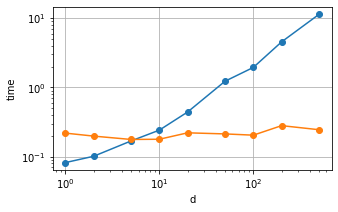

In [13]:
# YOUR CODE HERE
import timeit
from statistics import mean

dlist =  [1, 2, 5, 10, 20, 50, 100, 200, 500]
tlist  = []
tlist2 = []

for d in dlist:
    U, X, Y = data.toy(100, 100, d)  
    # get the average of three runs
    delta  = mean(timeit.repeat(lambda : pybatch(U,X,Y), number=1, repeat=3))
    tlist.append(delta)
    delta2 = mean(timeit.repeat(lambda : pybatch(U,X,Y,pynearest,npdistance), number=1, repeat=3))
    tlist2.append(delta2)

# Plot the results in a graph
fig = plt.figure(figsize=(5, 3))
plt.plot(dlist, tlist, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)                  
plt.plot(dlist, tlist2, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)
# YOUR CODE HERE


**c)** Based on your results, explain what kind of speedup `numpy` provides, and in what regime do you expect the speedup to be the most important:

**Note**: For this exercise you only need to provide a free text answer


#### Explain the speedup that numpy provides



## 2. Accelerating the nearest neighbor search (25 P)

Motivated by the success of the `numpy` optimized distance computation, we would like further accelerate the code by performing nearest neighbor search directly in `numpy`.

**a)** Implement the function `npnearest(u,X,Y)` as an alternative to the function `pynearest(u,X,Y,distance=npdistance)` that we have used in the previous exercise. Again, verify your function for the same toy example as before (i.e. `data.toy(20,100,50)`).

Unlike `pynearest`, `npnearest` doesn't receive any distance argument. `npnearest` will work only with square eucledian distance. If you are confident that your `npdistance` implementation can work between a vector and a matrix, you are welcome to reuse it. It is however, perfectly acceptable to reimplement the distance algorithm in this function again.

Once again the use of `for loops`, or functions like `map` or `vectorize` is stictly not allowed in this exercise.

In [14]:
def npnearest(u: np.ndarray, X: np.ndarray, Y: np.ndarray, *args, **kwargs):
    '''
    Finds x1 so that x1 is in X and u and x1 have a minimal distance (according to the 
    provided distance function) compared to all other data points in X. Returns the label of x1
    
    Args:
        u (np.ndarray): The vector (ndim=1) we want to classify
        X (np.ndarray): A matrix (ndim=2) with training data points (vectors)
        Y (np.ndarray): A vector containing the label of each data point in X
        args, kwargs  : Ignored. Only for compatibility with pybatch
        
    Returns:
        int: The label of the data point which is closest to `u`
    '''
    # YOUR CODE HERE
    
    xd = (u-X)**2
    y = np.sum(xd, 1)
    #x  = xd.argmin()
      
    return Y[y.argmin()]    
    # YOUR CODE HERE
    

In [15]:
TINY_U, TINY_X, TINY_Y = data.toy(3,3,3)
tiny_u = TINY_U[0]
print('u')
pprint(tiny_u)
print('\nX')
pprint(TINY_X)
print('\nY')
pprint(TINY_Y)

np_nearest = npnearest(tiny_u, TINY_X, TINY_Y)
expected_nearest = pynearest(tiny_u, TINY_X, TINY_Y)
print(f'\nnp_nearest --> {np_nearest}')
print(f'expected_nearest --> {expected_nearest}')

t.assertEqual(expected_nearest, np_nearest)

# Verify your function
np.testing.assert_allclose(
    pybatch(U, X, Y, nearest=pynearest), 
    pybatch(U, X, Y, nearest=npnearest)
)

u
array([0.69646919, 0.28613933, 0.22685145])

X
array([[0.24875591, 0.16306678, 0.78364326],
       [0.80852339, 0.62562843, 0.60411363],
       [0.8857019 , 0.75911747, 0.18110506]])

Y
array([1, 0, 0])

np_nearest --> 0
expected_nearest --> 0


In [16]:
# This cell is for grading. DO NOT remove it

**b)** Create a plot similar to the one above, where the new method is compared to the previous one. This means that you should compare the runtime of `npnearest` and `pynearest` with `npdistance` as its distance function. Here, we fix `M=100`, `d=100`, and we let `N` take different values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`.

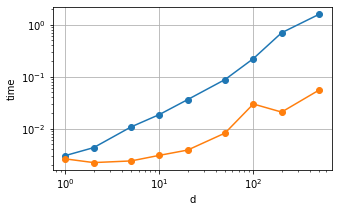

In [17]:
# YOUR CODE HERE
import timeit
from statistics import mean


Nlist =  [1, 2, 5, 10, 20, 50, 100, 200, 500]
tlist  = []
tlist2 = []

for n in Nlist:
    U, X, Y = data.toy(100, n, 100)  
    # get the average of three runs
    delta  = mean(timeit.repeat(lambda : pybatch(U,X,Y, pynearest, npdistance), number=1, repeat=3))
    tlist.append(delta)
    delta  = mean(timeit.repeat(lambda : pybatch(U,X,Y, npnearest, npdistance), number=1, repeat=3))
    tlist2.append(delta)
    
# Plot the results in a graph
fig = plt.figure(figsize=(5, 3))
plt.plot(Nlist, tlist, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)                  
plt.plot(Nlist, tlist2, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)
# YOUR CODE HERE

## 3. Accelerating the processing of multiple test points (25 P)

Not yet fully happy with the performance of the algorithm, we would like to further optimize it by avoiding performing a loop on the test points, and instead, classify them all at once.

**a)** Implement the function `npbatch(U,X,Y)` as a replacement of the implementation `pybatch(U,X,Y,nearest=npnearest)` that we have built in the previous exercise. Inside this function, use [`scipy.spatial.distance.cdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) for the actual distance computation. Again, verify your function for the same toy example as before (i.e. `data.toy(20,100,50)`).

In [18]:
import scipy

# for some systems we need to import spatial explicitly
from scipy.spatial import distance
def npbatch(U, X, Y, *args, **kwargs):
    '''
    This function has the same functionality as the `pybatch` function.
    HOWEVER, the distance function is fixed (scipy.spatial.distance.cdist).
    It does not use any of the functions defined by us previously.
    
    Args:
        U (np.ndarray): A matrix (ndim=2) containing multiple vectors which we want to classify
        X (np.ndarray): A matrix (ndim=2) that represents the training data
        Y (np.ndarray): A vector (ndim=1) containing the labels for each data point in X
        
        All other arguments are ignored. *args, **kwargs are only there for compatibility 
        with the `pybatch` function
        
    Returns:
        np.ndarray: A vector (ndim=1) with the predicted label for each vector $u \in U$
    '''
    # YOUR CODE HERE
    d = distance.cdist(U, X)
    
    return Y[d.argmin(axis = 1)]
    
  
    # YOUR CODE HERE
    

In [19]:
print('U')
pprint(TINY_U)
print('\nX')
pprint(TINY_X)
print('\nY')
pprint(TINY_Y)

expected_output = pybatch(TINY_U, TINY_X, TINY_Y)
print(f'\nexpected_output --> {expected_output}')
actual_output = npbatch(TINY_U, TINY_X, TINY_Y)
print(f'actual_output --> {actual_output}')
np.testing.assert_allclose(expected_output, actual_output)

U, X, Y = data.toy(20,100,50)
np.testing.assert_allclose(pybatch(U, X, Y), npbatch(U, X, Y))

U
array([[0.69646919, 0.28613933, 0.22685145],
       [0.55131477, 0.71946897, 0.42310646],
       [0.9807642 , 0.68482974, 0.4809319 ]])

X
array([[0.24875591, 0.16306678, 0.78364326],
       [0.80852339, 0.62562843, 0.60411363],
       [0.8857019 , 0.75911747, 0.18110506]])

Y
array([1, 0, 0])

expected_output --> [0, 0, 0]
actual_output --> [0 0 0]


In [20]:
# This cell is for grading. DO NOT remove it

**b)** Create a plot comparing the computation time of the new implementation compared to the previous one. Here, we fix `N=100`, `d=100`, and we let `M` vary from `1` to `500` with values `[1, 2, 5, 10, 20, 50, 100, 200, 500]`.

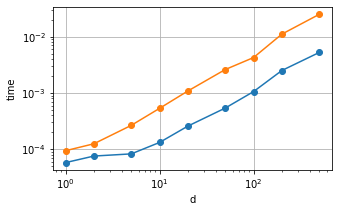

In [21]:
# YOUR CODE HERE
import timeit
from statistics import mean



Mlist =  [1, 2, 5, 10, 20, 50, 100, 200, 500]
tlist  = []
tlist2 = []

for m in Mlist:
    U, X, Y = data.toy(m, 100, 100)  
    # get the average of three runs
    delta  = mean(timeit.repeat(lambda : npbatch(U,X,Y), number=1, repeat=3))
    tlist.append(delta)
    delta  = mean(timeit.repeat(lambda : pybatch(U,X,Y, npnearest, npdistance), number=1, repeat=3))
    tlist2.append(delta)
    
# Plot the results in a graph
fig = plt.figure(figsize=(5, 3))
plt.plot(Nlist, tlist, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)                  
plt.plot(Nlist, tlist2, '-o')
plt.xscale('log'); plt.yscale('log'); plt.xlabel('d'); plt.ylabel('time'); plt.grid(True)
# YOUR CODE HERE
# YOUR CODE HERE


## 4. Application to real-world data (25 P)

Having now implemented an efficient K-nearest neighbor classifier, we can test it on real problems with many data points and dimensions. We consider a small handwritten digits recognition dataset, that can be directly obtained from the library `scikit-learn`. This dataset consists of handwritten digits of size `8 x 8` flattened into arrays of size `64`, with class between `0` and `9`. We use a function `data.digits()` to load the data and arrange data points in some predefined order.

In [22]:
X, Y = data.digits()
print(f'Shape of data: {X.shape}')
print(f'Shape of labels: {Y.shape}')

Shape of data: (1797, 64)
Shape of labels: (1797,)


**a) 10P** Using the function `imshow` of `matplotlib.pyplot (plt)` to visualize the first 16 digits (in a `4x4` grid) of the dataset. You get 8 points for a correct implementation and 2 points for an implementation that doesn't use any for loops.

**Note**: Your solution should output exactly one plot and shouldn't create new figures i.e. call `plt.show` or use `plt.figure` in a loop. The image will still be shown in the next cell, since we have configured matplotlib, to call plt.show, at the end of each cell.

In [23]:
def plot_first_digits():
    '''
    Loads the digit dataset and plots the first 16 digits in one image
    You are encouraged to implement this functions without 
    the use of any for-loops
    '''
    
    # YOUR CODE HERE
    
    X, Y = data.digits()
    
    A = X[:16]
    
    x = []
    #y = np.array(x)
    
    
    for m in A:
        b = np.reshape(m, (8,8))
        x.append(b)
      
    #y = np.array(x)                
    s = np.reshape(x, (32,32))             
    matplotlib.pyplot.imshow(s)
        
    # YOUR CODE HERE
    

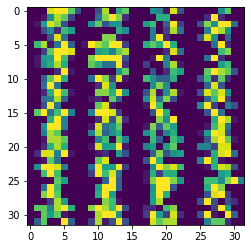

In [24]:
plot_first_digits()


**b)**
* Partition the data into a "training" set and "test" set. The training set contains the first 1000 digits of `X`, and the test set contains the remaining ones.

* Assume that you don't know the labels for the test data and classify the test data using your efficient nearest neighbor implementation.

* Print the predicted labels for the test set.

In [31]:
def train_test_split(x: np.ndarray, y: np.ndarray):
    '''
    Splits the data into train and test sets
    The first 1000 samples belong to the training set the rest to the test set
    
    Args:
        x (np.ndarray): A matrix (ndim=2) containing the data
        y (np.ndarray): A vector (ndim=1) containing the label for each datapoint
    
    Returns:
        tuple: A tuple containing 4 elements. The training data, the test data, the training labels 
            and the test labels
    '''
    # YOUR CODE HERE
    
    trainset = x[:1000]
    testset = x[1000:]
    trainlabels = y[:1000]
    testlabels = y[1000:]
    
    return trainset, testset, trainlabels, testlabels
    

    # YOUR CODE HERE
    
    

def predict(x_train, x_test, y_train):
    '''
    For each x in x_test this function finds the nearest neighbour in x_train and 
    returns that label
    
    This function is a wrapper of the `npbatch` function
    
    Args: 
        x_train (np.ndarray): A matrix (ndim=2) containing all the training data
        x_test (np.ndarray):  A matrix (ndim=2) containing all the test data for which we want a prediction
        y_train (np.ndarray): A vector (ndim=1) containing the label of each datapoint in the training set
        
    Returns: 
        np.ndarray: A vector with the prediction for each datapoint/vector in x_test
    '''
    # YOUR CODE HERE
    
    y_test_predict = npbatch(x_test, x_train, y_train)
   
    
    # YOUR CODE HERE
    
    return y_test_predict

In [32]:
train_test_output = train_test_split(X, Y)
x_train, x_test, y_train, y_test = train_test_output

# check if types match
t.assertIsInstance(x_train, np.ndarray)
t.assertIsInstance(x_test, np.ndarray)
t.assertIsInstance(y_train, np.ndarray)
t.assertIsInstance(y_test, np.ndarray)

# check if shapes match
t.assertEqual(x_train.shape, (1000, 64))
t.assertEqual(x_test.shape, (797, 64))
t.assertEqual(y_train.shape, (1000,))
t.assertEqual(y_test.shape, (797,))

# check that first values match
t.assertEqual(y_train[0], 7)
t.assertEqual(y_test[0], 0)



In [33]:
# This cell is for grading. DO NOT remove it

In [34]:
# check if prediction shape matches
predictions = predict(x_train, x_test, y_train)
t.assertEqual(predictions.shape, (797,))

first_three = predictions[:3]
print(f'first_three --> {first_three}')

expected_first_three = pybatch(x_test[:3], x_train, y_train)
print(f'expected_first_three --> {expected_first_three}')

np.testing.assert_allclose(first_three, expected_first_three)

first_three --> [0 7 3]
expected_first_three --> [0, 7, 3]


In [35]:
# This cell is for grading. DO NOT remove it

**c)** 
* Finally, in order to determine the accuracy of the classifier, we would like to compare the predictions with the ground truth (i.e. the true labels from the test data).

* Compute the fraction of the test set where the predictions of the nearest neighbor algorithm and labels disagree. 

In [44]:
def evaluate(x_train, x_test, y_train, y_test) -> float:
    '''
    Evaluates the accuracy of our nearest neighbor classifier
    by calculating the ratio of test samples for which 
    our classification method disagrees with the ground truth
    
    Args:
        x_train (np.ndarray): A matrix (ndim=2) containing the training data for the classifier
        x_test (np.ndarray): A matrix (ndim=2) containing the test data for which the classifier 
            will make a prediction
        y_train (np.ndarray): The labels for the training data
        y_test (np.ndarray): The labels for the test data 
    Returns:
        float: The ratio in [0-1] of the test samples for which our 
            nearest neighbor classifier disagrees with the provided labels
    '''
    # YOUR CODE HERE
    y_test_predict = npbatch(x_test, x_train, y_train)
    
    disagreement = 0
    
    for i in range(0, len(y_test)):
        if(y_test_predict[i] != y_test[i]):
         disagreement = disagreement + 1 
        
    return disagreement/len(y_test) 
        
    # YOUR CODE HERE
    

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
ratio_disagree = evaluate(x_train, x_test, y_train, y_test)
print(f'ratio_disagree --> {ratio_disagree}')

# make sure this is a percentage
t.assertGreaterEqual(ratio_disagree, 0., 'A percentage cannot be less than 0')
t.assertLessEqual(ratio_disagree, 1., 'A percentage cannot be more that 1')

# Upper bound for disagree ratio
t.assertLess(ratio_disagree, 0.01, 'Your solution should return less than 0.01')

ratio_disagree --> 0.00878293601003764
